# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 15

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 459
Num noneffect sequences: 	 459
Num scores: 	 	 	 459


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.473072109975868
Median KS-test p-value: 	 0.44873067620892737
St. Dev KS-test p-value: 	 0.313555962763823
Max KS-test p-value: 	 	 0.9989529735884094
Min KS-test p-value: 	 	 9.49005219633571e-13
Num significant p-values: 	 14

Mean non-zero motif length: 	 8.823008849557523
Median non-zero motif length: 	 8.0
St. Dev non-zero motif length: 	 5.903264766769995
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.710239651416122
Median motif length: 	 	 10
St. Dev motif length: 	 	 2.8069089253781576
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 415


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 415


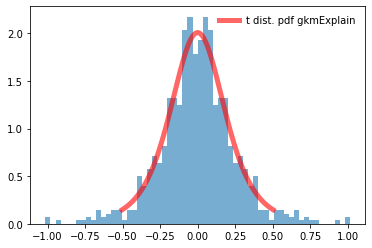

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 4.398798056369456
Mean: 	 3.6451269146443764e-07
Stdev: 	 0.187858226701551

KstestResult(statistic=0.01604482509834204, pvalue=0.9831466329486954)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 200


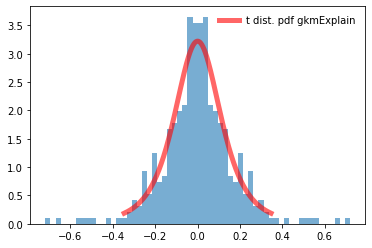

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 3.3189258242584687
Mean: 	 -5.384865225567319e-08
Stdev: 	 0.11493717874559221

KstestResult(statistic=0.028134124597635868, pvalue=0.9095172387927046)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 200


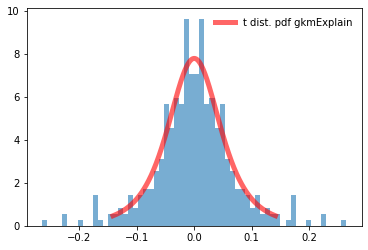

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 3.4456505831857465
Mean: 	 1.1272814887253025e-07
Stdev: 	 0.047729267280875634

KstestResult(statistic=0.017505651366183317, pvalue=0.9996952703892965)


## Distribution of ISM Scores

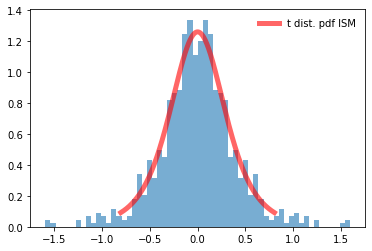

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 4.3656477717487245
Mean: 	 -6.347625968237549e-07
Stdev: 	 0.2988253360667562

KstestResult(statistic=0.014677908206637336, pvalue=0.9940217989155136)


## Distribution of Delta Scores

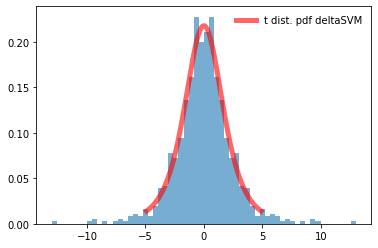

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 3.727314449766693
Mean: 	 1.0217832499946535e-05
Stdev: 	 1.7143147062673818

KstestResult(statistic=0.012672370948676237, pvalue=0.9993439573142808)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.503447748643559
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.3466789301039634
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.07551708434284493
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.1413644660638247
Negative ISM Cutoff: 	 	 	 	 	 -0.802973008448886
Negative deltaSVM Cutoff: 	 	 	 	 -4.900214894922091

Total SNPs with Negative Scores: 	 	 	 10
Confident SNPs with Negative Scores: 	 	 	 5
Highly Confident SNPs with Negative Scores: 	 	 4


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
358,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.075419,0.748446,0.044767,0.269550,-0.781612,-0.655714,-0.224783,-1.230653,-7.090855,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGT,GAGGGTGCTGT,0.011586,0.008069,0.013196,0.012215,0.016664,0.492130,2
94,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.273939,0.992986,0.086879,0.257751,-0.726001,-0.718382,-0.170872,-1.133768,-6.685600,Alzheimers_Lambert_2013,4.789000e-05,True,True,GGCCCCGCCCC,GGCCTCGCCCC,0.015105,0.006087,0.029719,0.016348,0.020051,0.017784,2
151,chr17,45947195,45947196,rs62062785,T,G,G,"A,T",G,"A,T",-,54,0.291774,0.774554,0.150459,0.313662,-0.555909,-0.482780,-0.163203,-0.870176,-5.075974,23andme_PD_hg38,3.333700e-22,True,True,CCCAGTGGCTGCC,CCCAGTGTCTGCC,0.036948,0.020127,0.033827,0.039209,0.045349,0.597829,2
262,chr19,44846144,44846145,rs3810143,C,T,T,"C,G",T,"C,G",+,71,0.211607,0.765849,0.072933,0.214645,-0.668343,-0.554242,-0.141712,-1.089062,-6.301895,Alzheimers_Jansen_2018,5.975633e-50,True,True,ATTCTTTGGCA,ATTCTTCGGCA,0.020161,0.013421,0.049677,0.018800,0.024062,0.073653,2
316,chr2,95057163,95057164,rs872580,C,A,C,A,A,C,-,85,-0.025966,0.184339,0.005797,0.093571,-0.589171,-0.175622,-0.087774,-0.914069,-5.320244,Nalls_23andMe,4.037170e-02,False,False,CATGGCACTC,CATGGCCCTC,0.030701,0.215368,0.151183,0.033601,0.039709,0.998953,1
379,chr3,122416407,122416408,rs55911744,T,G,T,G,T,G,-,86,-0.054423,0.092040,0.002445,0.042645,-0.546801,-0.087397,-0.040200,-0.859688,-4.960456,Nalls_23andMe,4.986370e-04,False,True,ACCGGACGCG,ACCTGACGCG,0.038905,0.497417,0.454113,0.040703,0.048345,0.097011,0
315,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,-0.052860,0.036925,0.000000,0.037785,-0.705012,-0.036925,-0.037785,-1.121150,-6.457090,Alzheimers_Jansen_2018,1.215671e-04,True,True,GACCGCCTCC,GACCCCCTCC,0.016751,0.767198,0.479466,0.017000,0.022332,0.228418,0
212,chr17,75032747,75032748,rs7218004,A,G,G,A,G,A,+,61,-0.038148,0.031455,0.000000,0.014756,-0.551988,-0.031455,-0.014756,-0.860446,-4.946109,Alzheimers_Kunkle_2019,8.541000e-06,True,True,CGGGCGGGTT,CGGGCAGGTT,0.037777,0.800502,0.774970,0.040593,0.048733,0.174787,0
322,chr2,95323523,95323524,rs3755519,T,A,A,"C,G,T",T,"A,C,G",+,85,0.000000,0.000000,0.000000,0.000000,-1.007876,0.000000,0.000000,-1.585309,-9.116166,Nalls_23andMe,7.682450e-03,False,False,CAGGAGTGCT,CAGGTGTGCT,0.004432,1.000000,0.999998,0.004732,0.007318,0.445310,0
274,chr19,44905909,44905910,rs440446,C,G,C,"G,T",G,"C,T",-,71,0.000000,0.000000,0.000000,0.000000,-0.611268,0.000000,0.000000,-0.963812,-5.497392,Alzheimers_Jansen_2018,1.809123e-142,True,True,GGAAGCCCTG,GGAACCCCTG,0.027223,1.000000,0.999998,0.028329,0.036138,0.378746,0



Positive Original gkmExplain Cutoff: 	 	 	 0.5034484776689417
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.3466788224066587
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.07551730979914269
Positive Ratio Difference gkmExplain High Cutoff: 	 0.1413646915201224
Positive ISM Cutoff: 	 	 	 	 	 0.8029717389236921
Positive deltaSVM Cutoff: 	 	 	 	 4.9002353305870905

Total SNPs with Positive Scores: 	 	 	 11
Confident SNPs with Positive Scores: 	 	 	 6
Highly Confident SNPs with Positive Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
235,chr19,18438073,18438074,rs2303696,C,T,T,C,C,T,+,69,0.556932,0.028960,0.221703,0.025086,0.599487,0.508612,0.196617,0.963063,5.435024,Alzheimers_Kunkle_2019,1.893000e-05,True,True,CCCCGCCCC,CCCTGCCCC,0.029017,0.017297,0.019764,0.028400,0.037350,0.255151,2
206,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.894929,0.329173,0.272481,0.129750,0.638281,0.546156,0.142731,1.014171,5.861786,23andme_PD_hg38,9.492900e-14,True,True,CGCCACCTAC,AGCCACCTAC,0.023573,0.014021,0.048744,0.023943,0.029932,0.769340,2
166,chr17,45955821,45955822,rs112950348,G,A,G,"A,C",G,"A,C",+,54,0.213675,-0.103109,0.127588,0.000000,0.664732,0.213675,0.127588,1.058590,6.119844,23andme_PD_hg38,3.191680e-22,True,True,CTCCGCCTCC,CTCCACCTCC,0.020539,0.151072,0.065121,0.020719,0.026304,0.824395,1
152,chr17,45947293,45947294,rs62062786,G,C,G,"A,C",G,"A,C",+,54,0.192234,-0.284357,0.127023,0.000000,0.913757,0.192234,0.127023,1.489188,8.526657,23andme_PD_hg38,4.529580e-22,True,True,CAGCTGCCAC,CACCTGCCAC,0.006470,0.184193,0.065850,0.006017,0.009152,0.776566,1
439,chr8,11845330,11845331,rs1736081,T,G,T,G,T,G,+,122,0.117273,-0.145202,0.122384,0.000000,0.667886,0.117273,0.122384,1.039497,5.988218,Chang_23andMe_Parkinsons,1.114750e-04,False,True,CTGTTGGCCC,CTGTGGGCCC,0.020209,0.376096,0.072221,0.022038,0.028084,0.147859,1
29,chr11,65889092,65889093,rs2231884,T,C,C,T,C,T,-,13,0.224884,-0.053430,0.161084,0.054238,0.559498,0.160167,0.106846,0.875119,5.015640,Alzheimers_Jansen_2018,2.368098e-06,True,True,TTCAAAAGC,CTCAAAAGC,0.036208,0.249490,0.099567,0.038526,0.046886,0.374559,1
446,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.042202,-0.054975,0.026301,0.000000,0.728504,0.042202,0.026301,1.137654,7.488772,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,CCCCCGCCGC,0.014922,0.735669,0.615357,0.016153,0.013995,0.572362,0
321,chr2,95297493,95297494,rs2248415,G,C,C,"A,G,T",G,"C,A,T",+,85,0.030194,-0.067748,0.024271,0.000000,0.766031,0.030194,0.024271,1.230241,7.087679,Nalls_23andMe,7.828270e-03,False,True,GGGTGGGGGG,GGGTCGGGGG,0.012464,0.808257,0.641889,0.012230,0.016687,0.110474,0
97,chr17,4908319,4908320,rs7214776,C,T,T,C,T,C,+,55,0.000000,0.000000,0.000000,0.000000,0.646372,0.000000,0.000000,1.018015,5.848071,Alzheimers_Lambert_2013,4.266000e-05,True,True,CACCCGAGAG,CACCTGAGAG,0.022593,1.000000,0.999998,0.023642,0.030141,0.115184,0
284,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.000000,0.000000,0.000000,0.000000,0.597984,0.000000,0.000000,1.000149,5.775212,Alzheimers_Kunkle_2019,2.690000e-238,True,True,GGGTAGGGGG,GGGTGGGGGG,0.029255,1.000000,0.999998,0.025079,0.031282,0.713973,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 358

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.7484   ||   Center / 200bp : 0.2695

Noneffect Motif: GAGGGCGCTGT


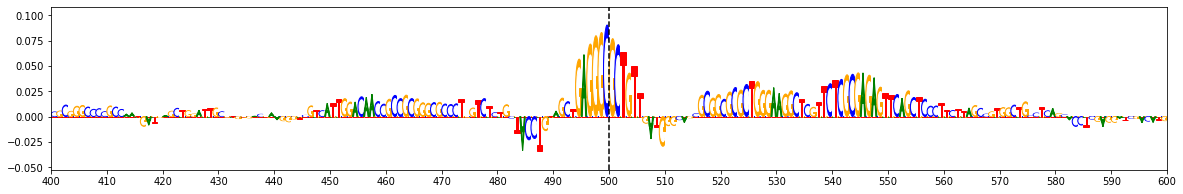

Effect Allele: T   ||   Effect Center: 0.0754   ||   Center / 200bp : 0.0448

Effect Motif: GAGGGTGCTGT


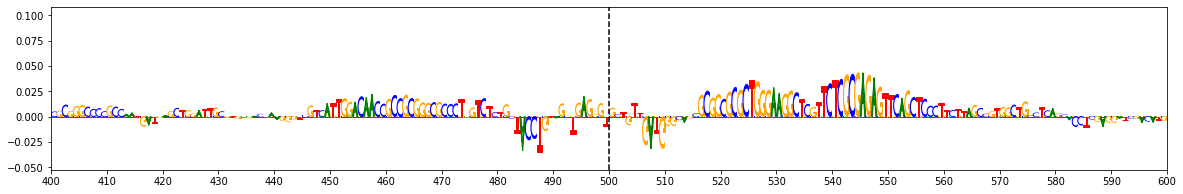

gkmExplain Score: -0.2248  ||  ISM Score: -1.2307  ||  deltaSVM Score: -7.0909

gkmExplain P-Value: 0.013196  ||  ISM P-Value: 0.012215  ||  deltaSVM P-Value: 0.016664

Difference Motif: GAGGG(C/T)GCTGT


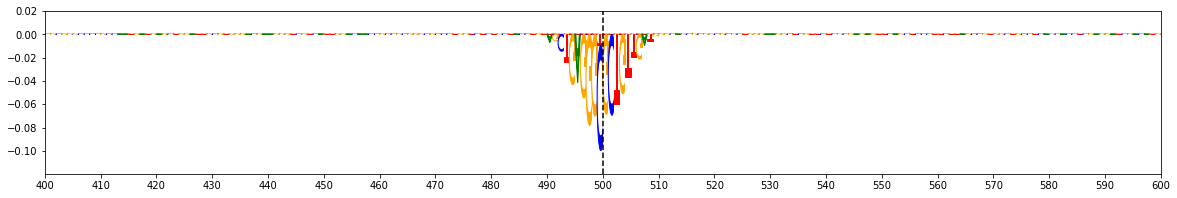



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 94

RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 55   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.7890E-05   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.993   ||   Center / 200bp : 0.2578

Noneffect Motif: GGCCCCGCCCC


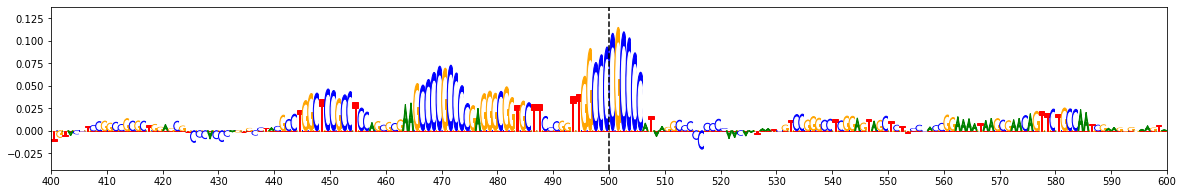

Effect Allele: T   ||   Effect Center: 0.2739   ||   Center / 200bp : 0.0869

Effect Motif: GGCCTCGCCCC


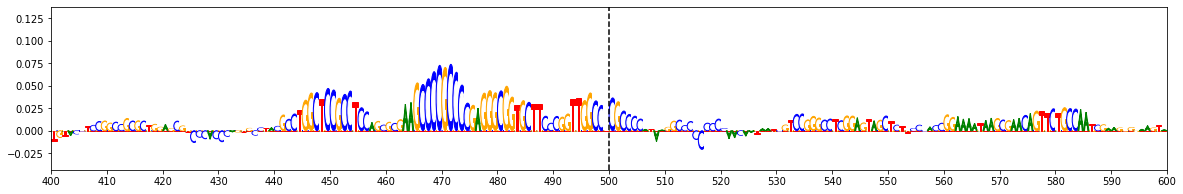

gkmExplain Score: -0.1709  ||  ISM Score: -1.1338  ||  deltaSVM Score: -6.6856

gkmExplain P-Value: 0.029719  ||  ISM P-Value: 0.016348  ||  deltaSVM P-Value: 0.020051

Difference Motif: GGCC(C/T)CGCCCC


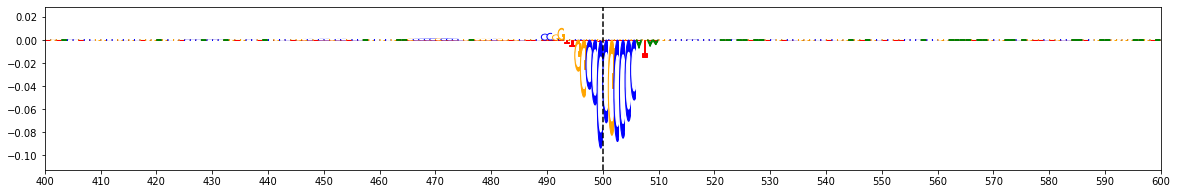



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 151

RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.3337E-22   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: G   ||   Noneffect Center: 0.7746   ||   Center / 200bp : 0.3137

Noneffect Motif: CCCAGTGGCTGCC


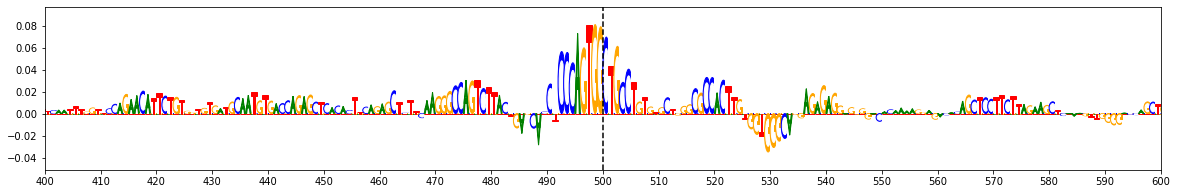

Effect Allele: T   ||   Effect Center: 0.2918   ||   Center / 200bp : 0.1505

Effect Motif: CCCAGTGTCTGCC


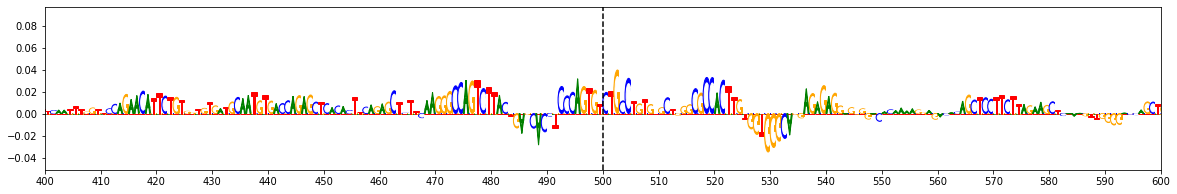

gkmExplain Score: -0.1632  ||  ISM Score: -0.8702  ||  deltaSVM Score: -5.076

gkmExplain P-Value: 0.033827  ||  ISM P-Value: 0.039209  ||  deltaSVM P-Value: 0.045349

Difference Motif: CCCAGTG(G/T)CTGCC


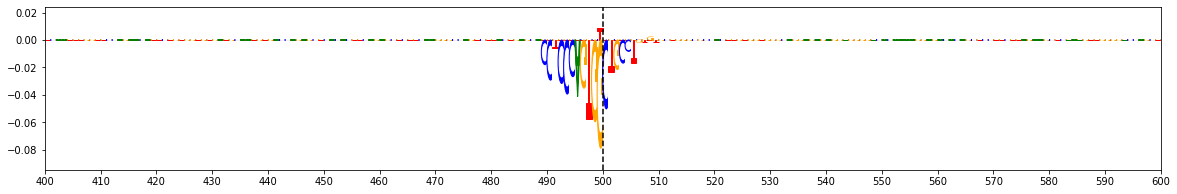



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 262

RSID: rs3810143   ||    chr19 : 44846144 - 44846145   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 5.9756E-50   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: T   ||   Noneffect Center: 0.7658   ||   Center / 200bp : 0.2146

Noneffect Motif: ATTCTTTGGCA


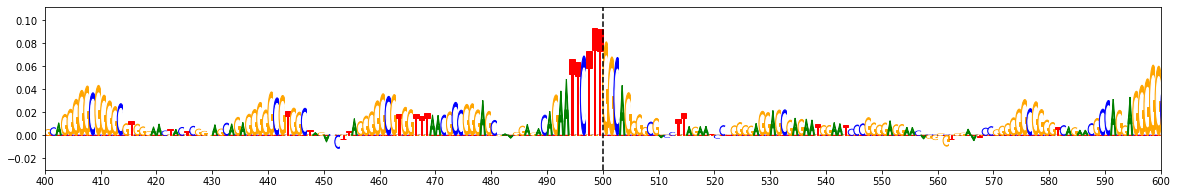

Effect Allele: C   ||   Effect Center: 0.2116   ||   Center / 200bp : 0.0729

Effect Motif: ATTCTTCGGCA


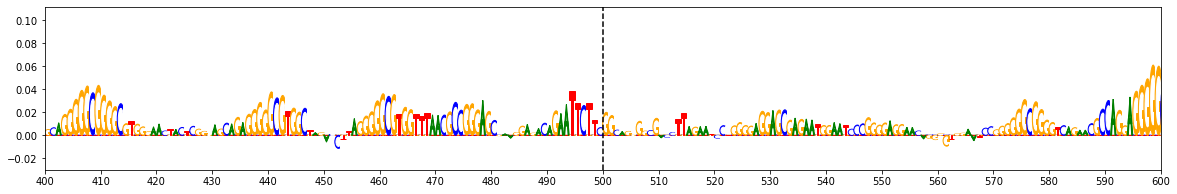

gkmExplain Score: -0.1417  ||  ISM Score: -1.0891  ||  deltaSVM Score: -6.3019

gkmExplain P-Value: 0.049677  ||  ISM P-Value: 0.0188  ||  deltaSVM P-Value: 0.024062

Difference Motif: ATTCTT(T/C)GGCA


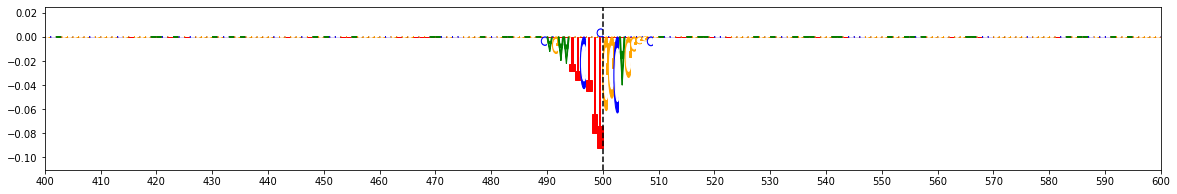



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 316

RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 85   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 4.0372E-02   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.1843   ||   Center / 200bp : 0.0936

Noneffect Motif: CATGGCACTC


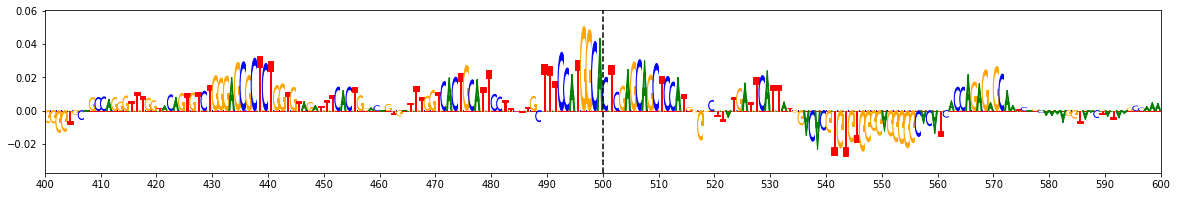

Effect Allele: C   ||   Effect Center: -0.026   ||   Center / 200bp : 0.0058

Effect Motif: CATGGCCCTC


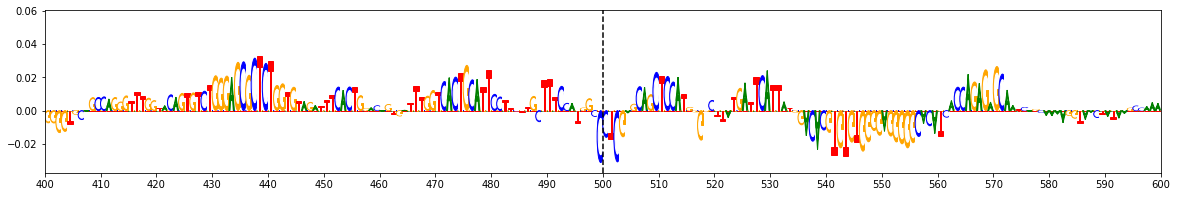

gkmExplain Score: -0.0878  ||  ISM Score: -0.9141  ||  deltaSVM Score: -5.3202

gkmExplain P-Value: 0.151183  ||  ISM P-Value: 0.033601  ||  deltaSVM P-Value: 0.039709

Difference Motif: CATGGC(A/C)CTC


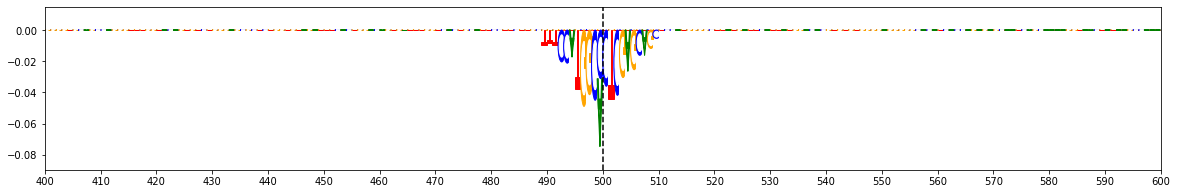



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 379

RSID: rs55911744   ||    chr3 : 122416407 - 122416408   ||    Locus: 86   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.9864E-04   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.092   ||   Center / 200bp : 0.0426

Noneffect Motif: ACCGGACGCG


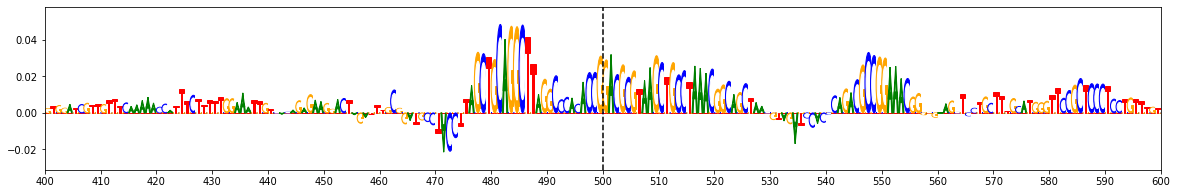

Effect Allele: T   ||   Effect Center: -0.0544   ||   Center / 200bp : 0.0024

Effect Motif: ACCTGACGCG


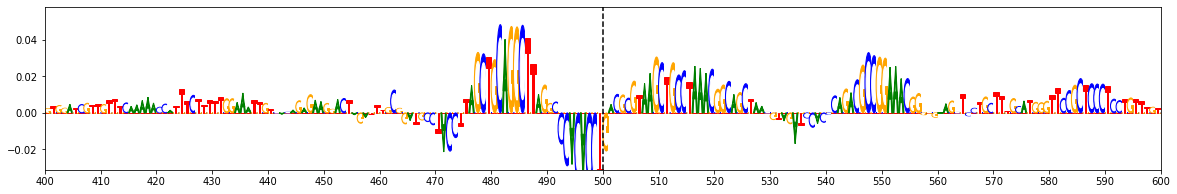

gkmExplain Score: -0.0402  ||  ISM Score: -0.8597  ||  deltaSVM Score: -4.9605

gkmExplain P-Value: 0.454113  ||  ISM P-Value: 0.040703  ||  deltaSVM P-Value: 0.048345

Difference Motif: ACC(G/T)GACGCG


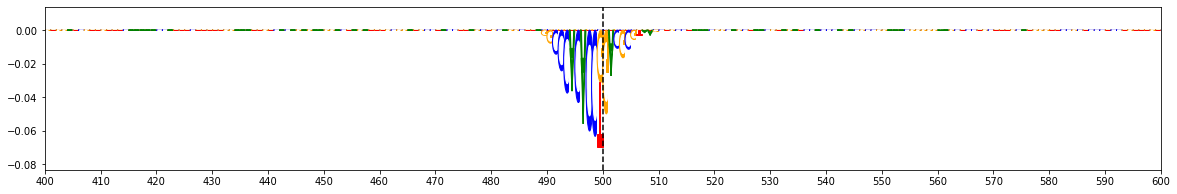



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 315

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0369   ||   Center / 200bp : 0.0378

Noneffect Motif: GACCGCCTCC


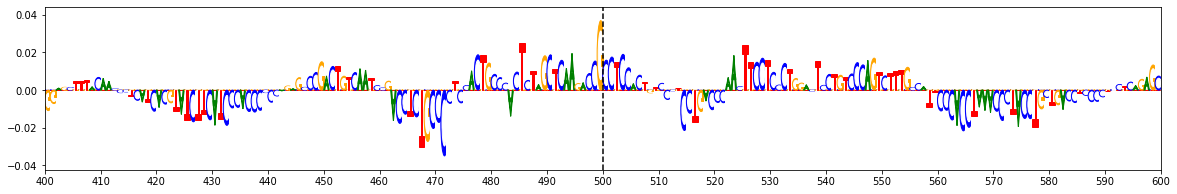

Effect Allele: C   ||   Effect Center: -0.0529   ||   Center / 200bp : 0.0

Effect Motif: GACCCCCTCC


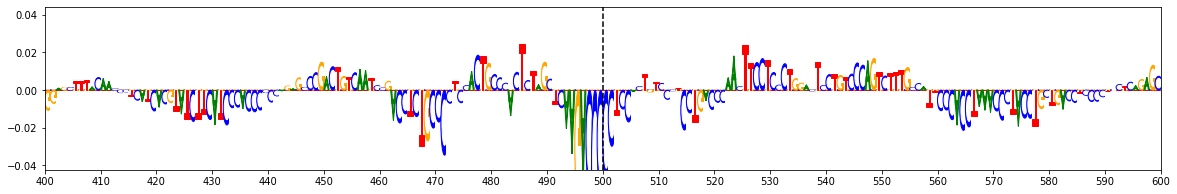

gkmExplain Score: -0.0378  ||  ISM Score: -1.1212  ||  deltaSVM Score: -6.4571

gkmExplain P-Value: 0.479466  ||  ISM P-Value: 0.017  ||  deltaSVM P-Value: 0.022332

Difference Motif: GACC(G/C)CCTCC


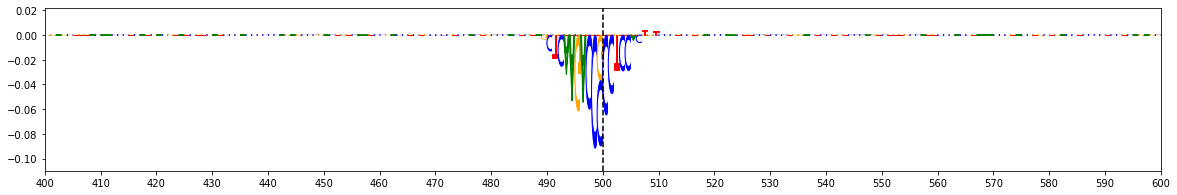



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 212

RSID: rs7218004   ||    chr17 : 75032747 - 75032748   ||    Locus: 61   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 8.5410E-06   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0315   ||   Center / 200bp : 0.0148

Noneffect Motif: CGGGCGGGTT


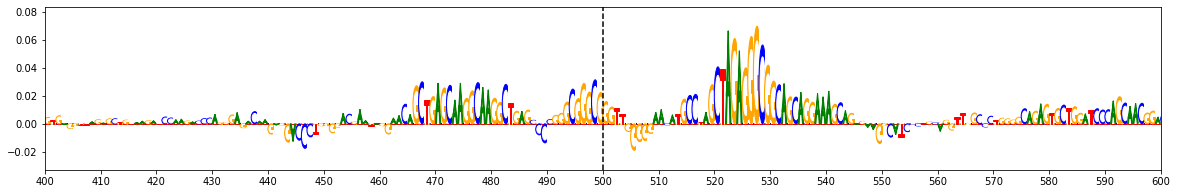

Effect Allele: A   ||   Effect Center: -0.0381   ||   Center / 200bp : 0.0

Effect Motif: CGGGCAGGTT


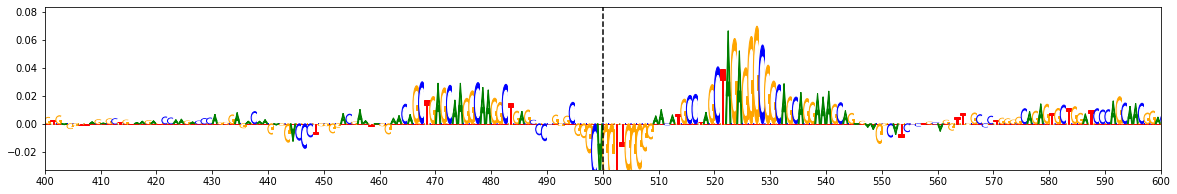

gkmExplain Score: -0.0148  ||  ISM Score: -0.8604  ||  deltaSVM Score: -4.9461

gkmExplain P-Value: 0.77497  ||  ISM P-Value: 0.040593  ||  deltaSVM P-Value: 0.048733

Difference Motif: CGGGC(G/A)GGTT


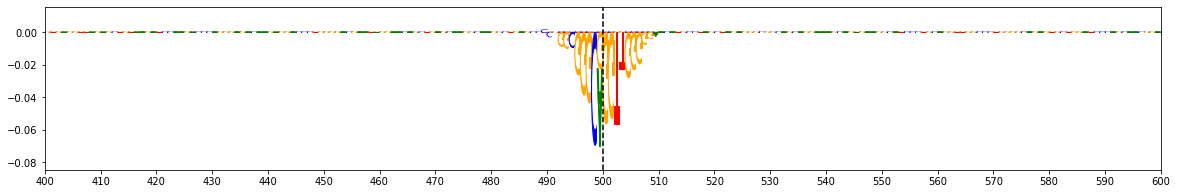



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 322

RSID: rs3755519   ||    chr2 : 95323523 - 95323524   ||    Locus: 85   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 7.6825E-03   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CAGGAGTGCT


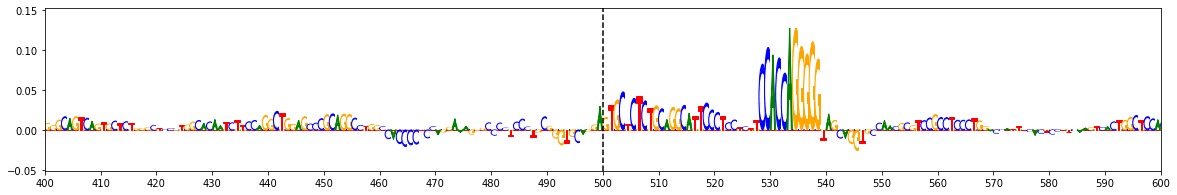

Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CAGGTGTGCT


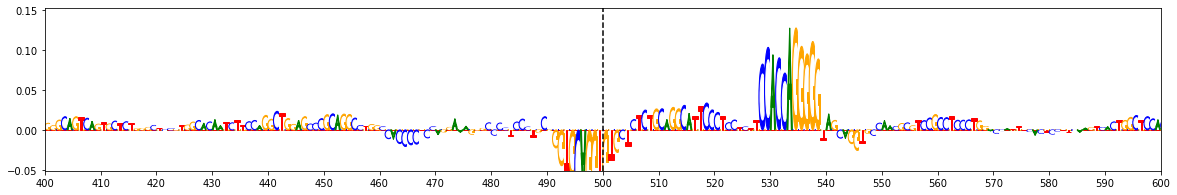

gkmExplain Score: 0.0  ||  ISM Score: -1.5853  ||  deltaSVM Score: -9.1162

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.004732  ||  deltaSVM P-Value: 0.007318

Difference Motif: CAGG(A/T)GTGCT


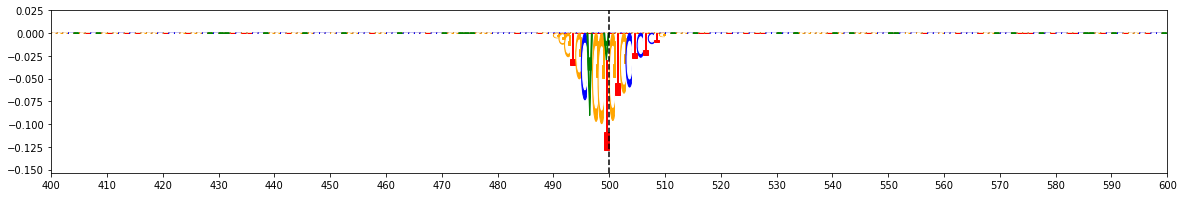



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 274

RSID: rs440446   ||    chr19 : 44905909 - 44905910   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.8091E-142   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGAAGCCCTG


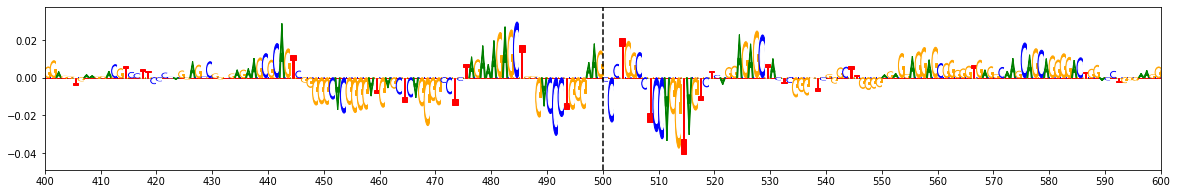

Effect Allele: C   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGAACCCCTG


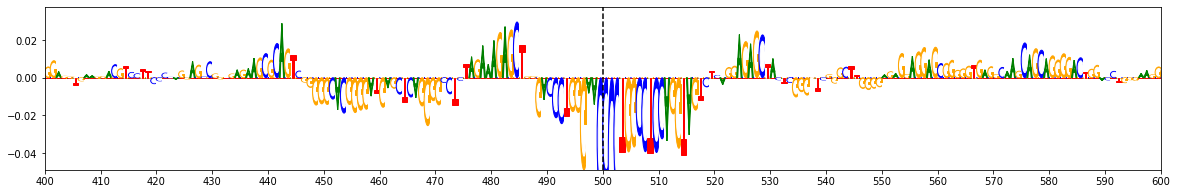

gkmExplain Score: 0.0  ||  ISM Score: -0.9638  ||  deltaSVM Score: -5.4974

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.028329  ||  deltaSVM P-Value: 0.036138

Difference Motif: GGAA(G/C)CCCTG


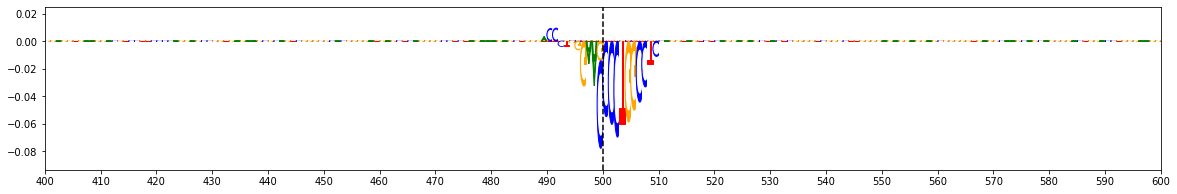



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 235

RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 69   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.8930E-05   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.5569   ||   Center / 200bp : 0.2217

Effect Motif: CCCCGCCCC


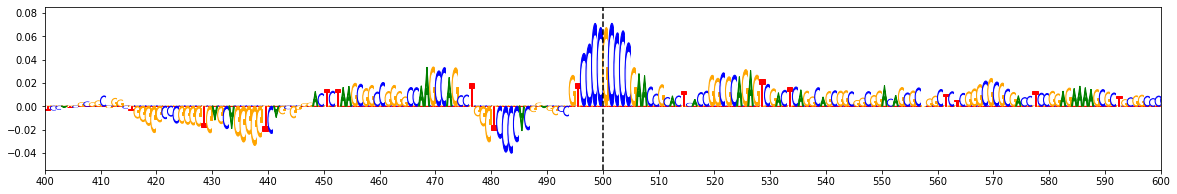

Noneffect Allele: T   ||   Noneffect Center: 0.029   ||   Center / 200bp : 0.0251

Noneffect Motif: CCCTGCCCC


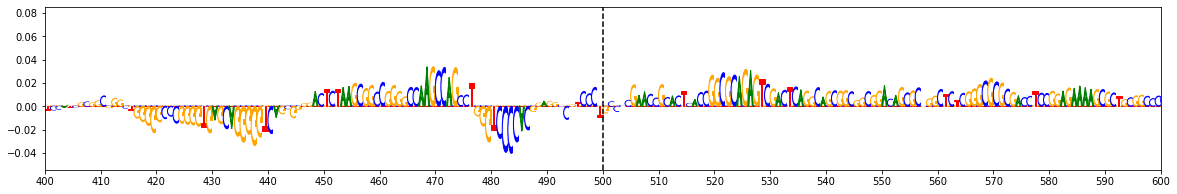

gkmExplain Score: 0.1966  ||  ISM Score: 0.9631  ||  deltaSVM Score: 5.435

gkmExplain P-Value: 0.019764  ||  ISM P-Value: 0.0284  ||  deltaSVM P-Value: 0.03735

Difference Motif: CCC(C/T)GCCCC


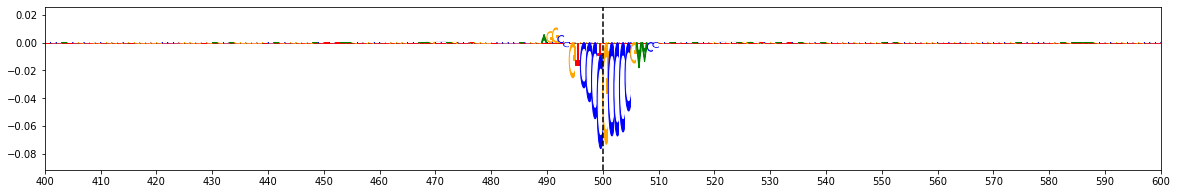



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 206

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.8949   ||   Center / 200bp : 0.2725

Effect Motif: CGCCACCTAC


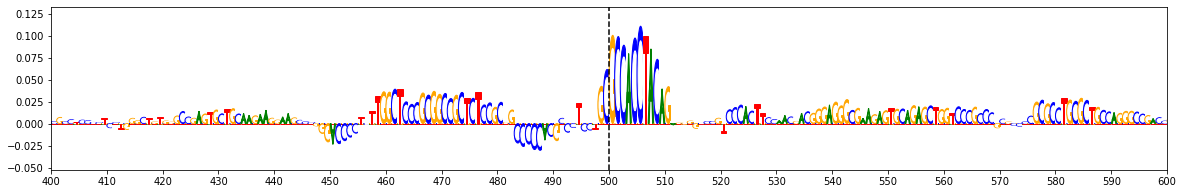

Noneffect Allele: A   ||   Noneffect Center: 0.3292   ||   Center / 200bp : 0.1298

Noneffect Motif: AGCCACCTAC


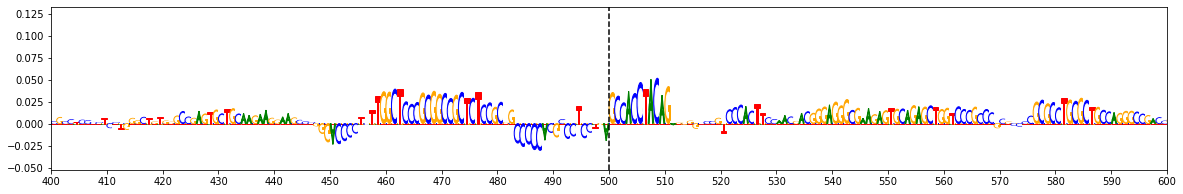

gkmExplain Score: 0.1427  ||  ISM Score: 1.0142  ||  deltaSVM Score: 5.8618

gkmExplain P-Value: 0.048744  ||  ISM P-Value: 0.023943  ||  deltaSVM P-Value: 0.029932

Difference Motif: (C/A)GCCACCTAC


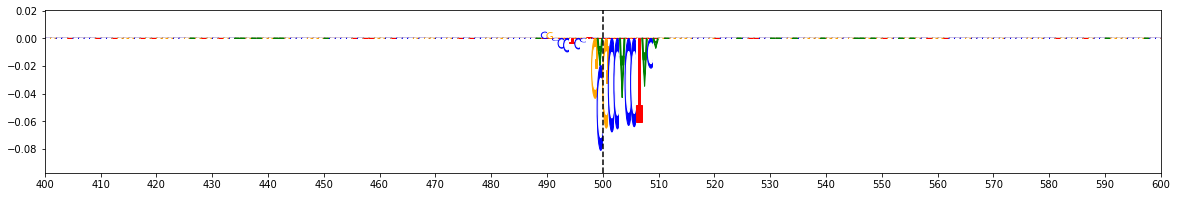



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 166

RSID: rs112950348   ||    chr17 : 45955821 - 45955822   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.1917E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.2137   ||   Center / 200bp : 0.1276

Effect Motif: CTCCGCCTCC


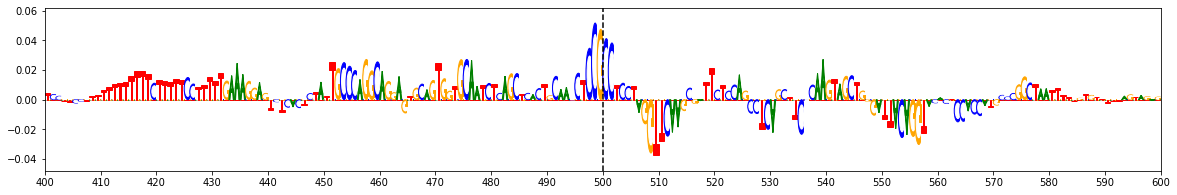

Noneffect Allele: A   ||   Noneffect Center: -0.1031   ||   Center / 200bp : 0.0

Noneffect Motif: CTCCACCTCC


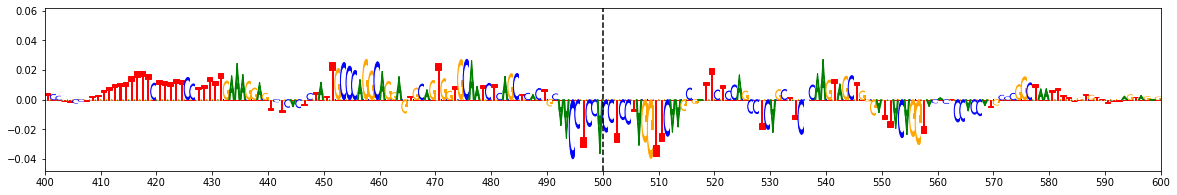

gkmExplain Score: 0.1276  ||  ISM Score: 1.0586  ||  deltaSVM Score: 6.1198

gkmExplain P-Value: 0.065121  ||  ISM P-Value: 0.020719  ||  deltaSVM P-Value: 0.026304

Difference Motif: CTCC(G/A)CCTCC


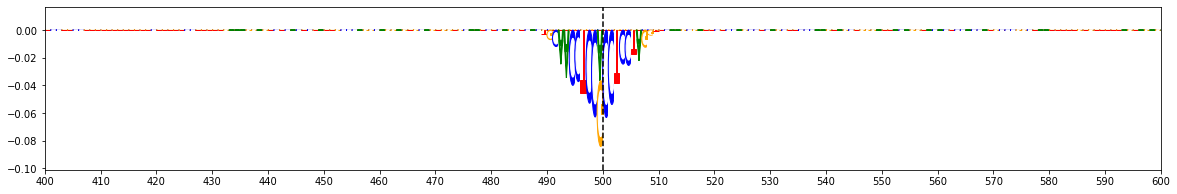



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 152

RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 4.5296E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.1922   ||   Center / 200bp : 0.127

Effect Motif: CAGCTGCCAC


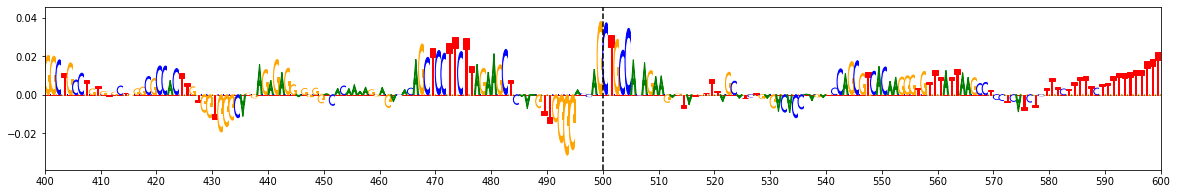

Noneffect Allele: C   ||   Noneffect Center: -0.2844   ||   Center / 200bp : 0.0

Noneffect Motif: CACCTGCCAC


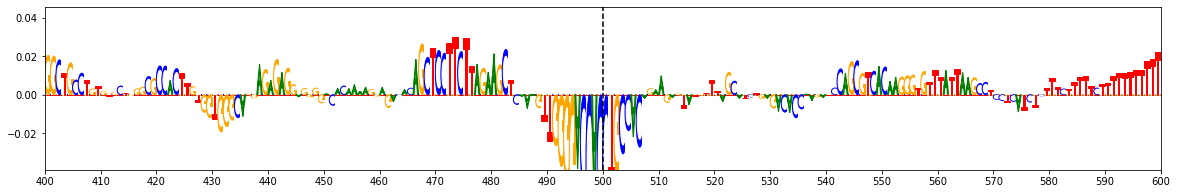

gkmExplain Score: 0.127  ||  ISM Score: 1.4892  ||  deltaSVM Score: 8.5267

gkmExplain P-Value: 0.06585  ||  ISM P-Value: 0.006017  ||  deltaSVM P-Value: 0.009152

Difference Motif: CA(G/C)CTGCCAC


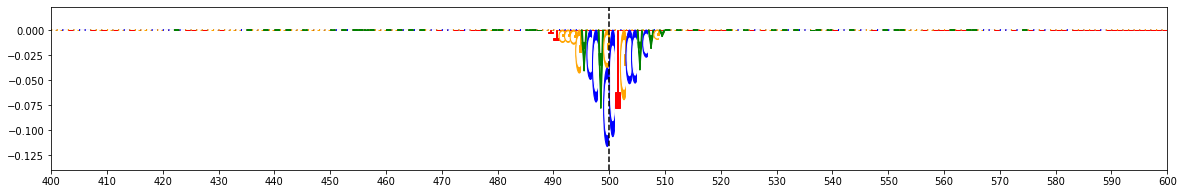



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 439

RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 122   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.1147E-04   ||    Coloc: False   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.1173   ||   Center / 200bp : 0.1224

Effect Motif: CTGTTGGCCC


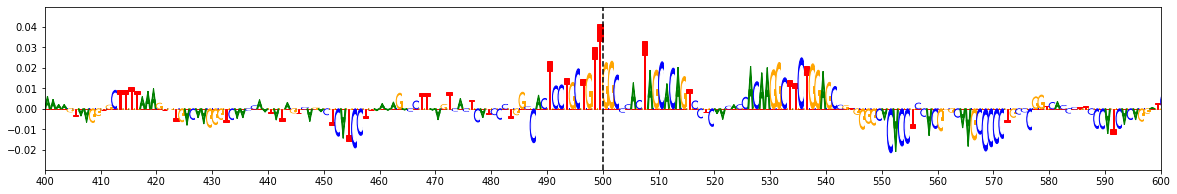

Noneffect Allele: G   ||   Noneffect Center: -0.1452   ||   Center / 200bp : 0.0

Noneffect Motif: CTGTGGGCCC


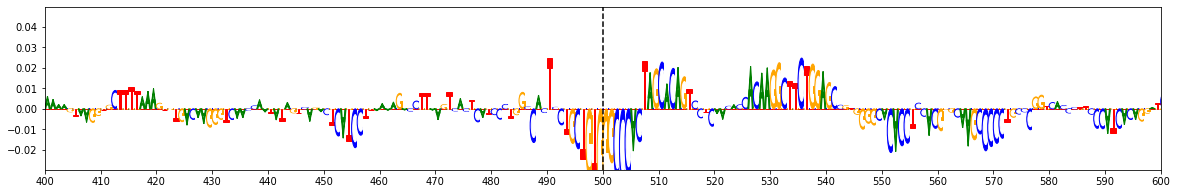

gkmExplain Score: 0.1224  ||  ISM Score: 1.0395  ||  deltaSVM Score: 5.9882

gkmExplain P-Value: 0.072221  ||  ISM P-Value: 0.022038  ||  deltaSVM P-Value: 0.028084

Difference Motif: CTGT(T/G)GGCCC


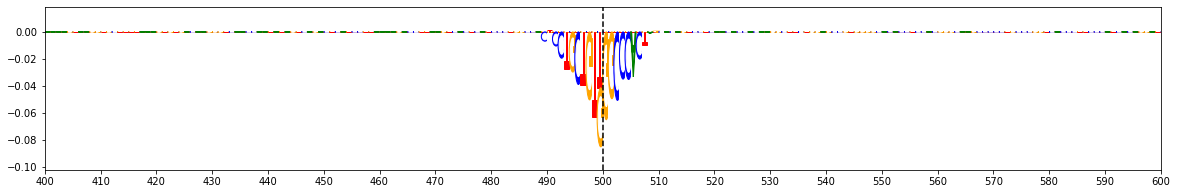



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 29

RSID: rs2231884   ||    chr11 : 65889092 - 65889093   ||    Locus: 13   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 2.3681E-06   ||    Coloc: True   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.2249   ||   Center / 200bp : 0.1611

Effect Motif: TTCAAAAGC


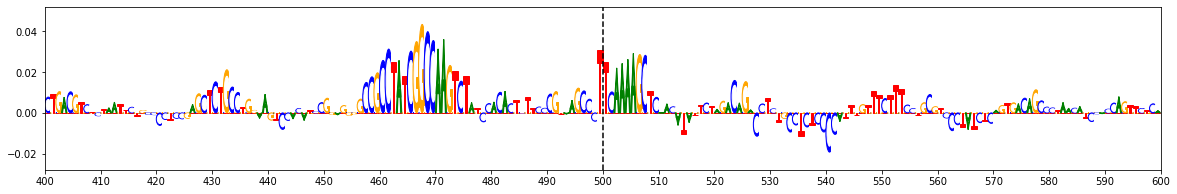

Noneffect Allele: C   ||   Noneffect Center: -0.0534   ||   Center / 200bp : 0.0542

Noneffect Motif: CTCAAAAGC


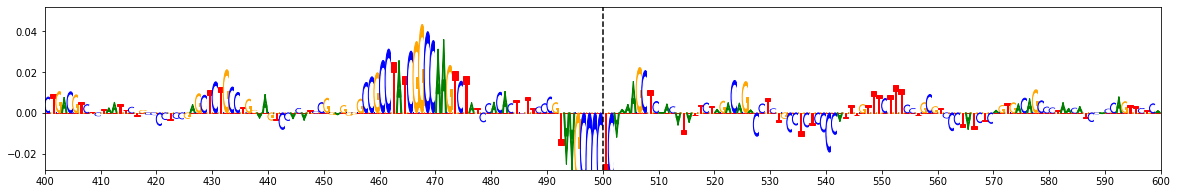

gkmExplain Score: 0.1068  ||  ISM Score: 0.8751  ||  deltaSVM Score: 5.0156

gkmExplain P-Value: 0.099567  ||  ISM P-Value: 0.038526  ||  deltaSVM P-Value: 0.046886

Difference Motif: (T/C)TCAAAAGC


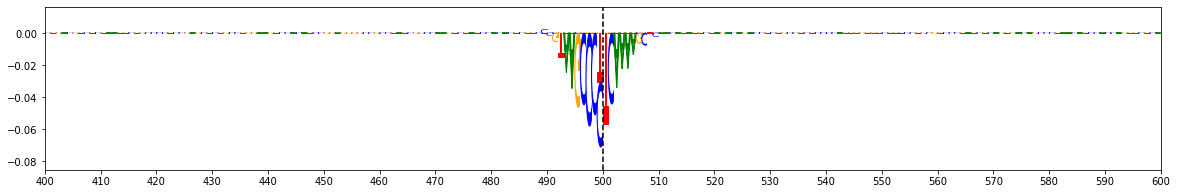



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 446

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0422   ||   Center / 200bp : 0.0263

Effect Motif: CCCCTGCCGC


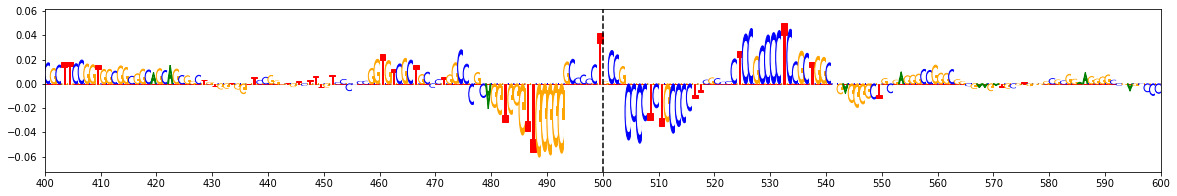

Noneffect Allele: C   ||   Noneffect Center: -0.055   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCCGCCGC


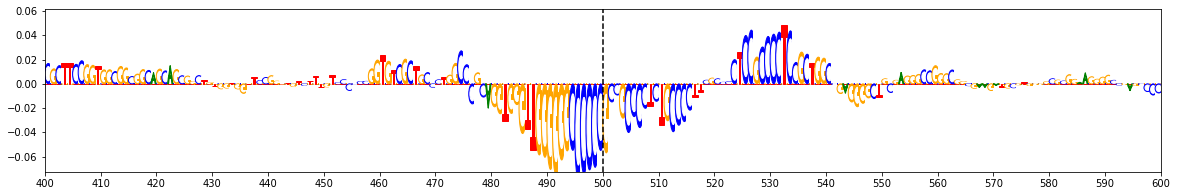

gkmExplain Score: 0.0263  ||  ISM Score: 1.1377  ||  deltaSVM Score: 7.4888

gkmExplain P-Value: 0.615357  ||  ISM P-Value: 0.016153  ||  deltaSVM P-Value: 0.013995

Difference Motif: CCCC(T/C)GCCGC


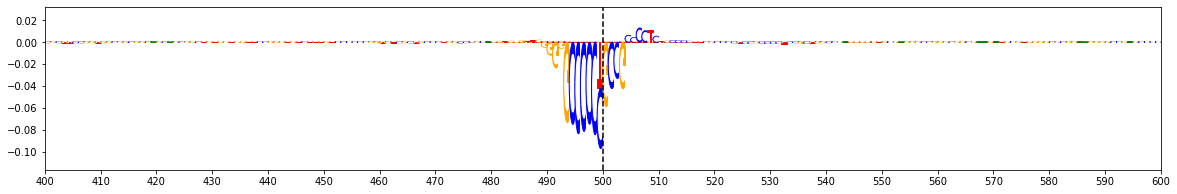



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 321

RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.8283E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0302   ||   Center / 200bp : 0.0243

Effect Motif: GGGTGGGGGG


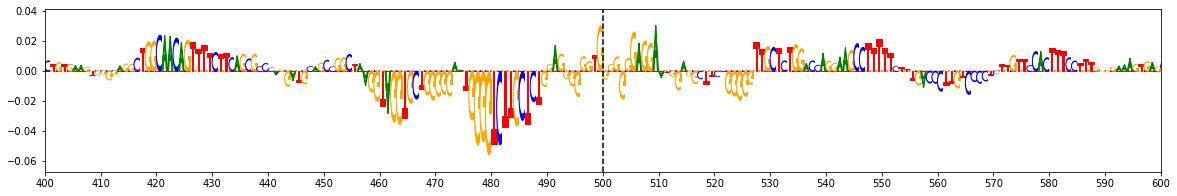

Noneffect Allele: C   ||   Noneffect Center: -0.0677   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTCGGGGG


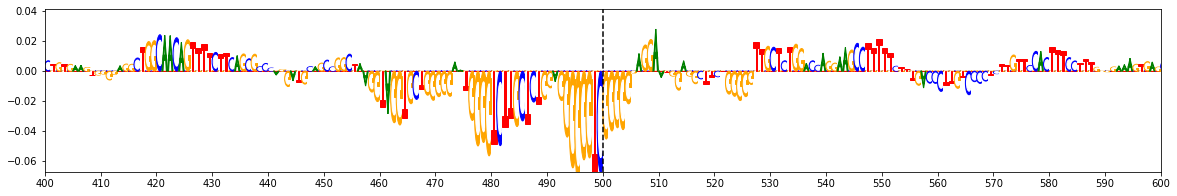

gkmExplain Score: 0.0243  ||  ISM Score: 1.2302  ||  deltaSVM Score: 7.0877

gkmExplain P-Value: 0.641889  ||  ISM P-Value: 0.01223  ||  deltaSVM P-Value: 0.016687

Difference Motif: GGGT(G/C)GGGGG


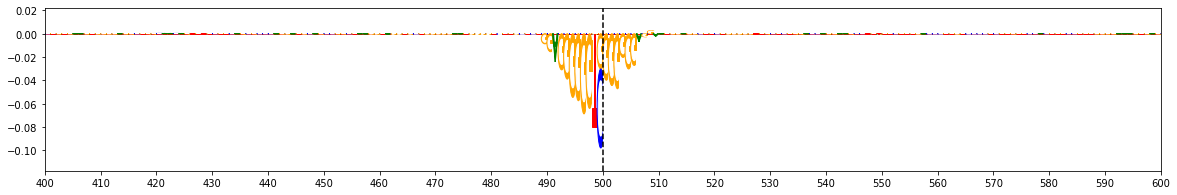



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 97

RSID: rs7214776   ||    chr17 : 4908319 - 4908320   ||    Locus: 55   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.2660E-05   ||    Coloc: True   ||    Confidence: 0


Effect Allele: C   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CACCCGAGAG


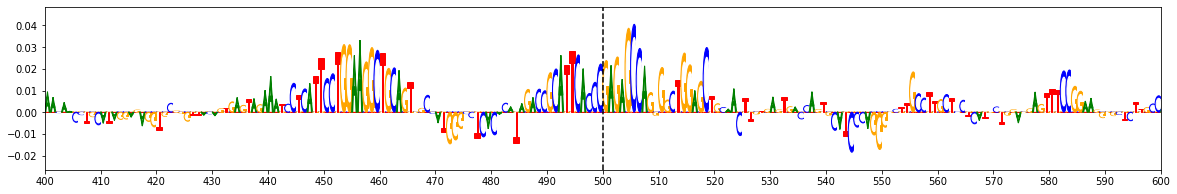

Noneffect Allele: T   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CACCTGAGAG


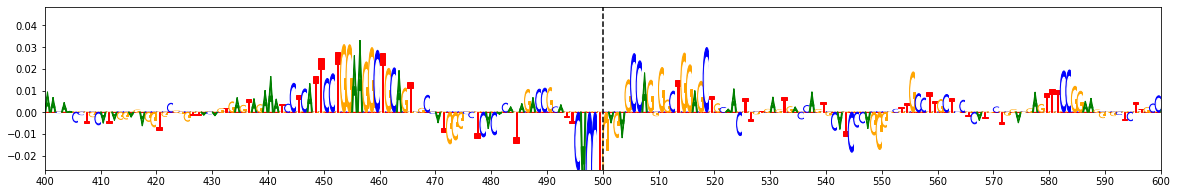

gkmExplain Score: 0.0  ||  ISM Score: 1.018  ||  deltaSVM Score: 5.8481

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.023642  ||  deltaSVM P-Value: 0.030141

Difference Motif: CACC(C/T)GAGAG


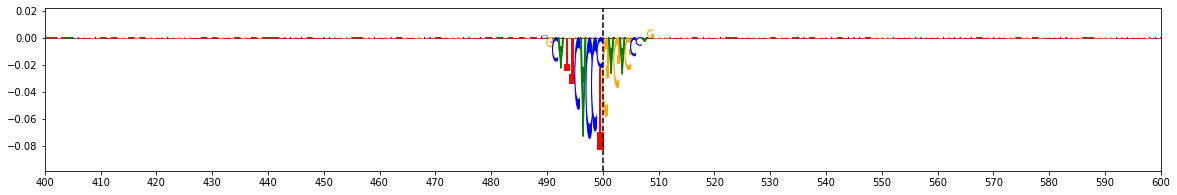



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 284

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


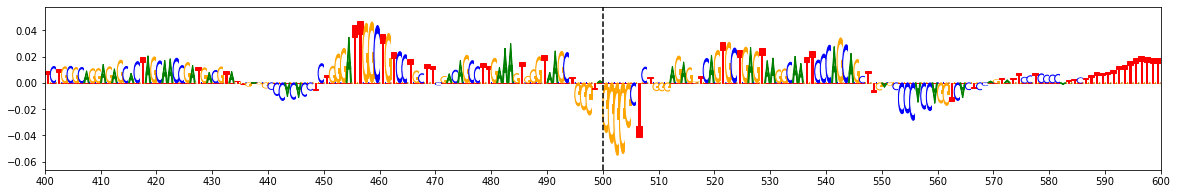

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


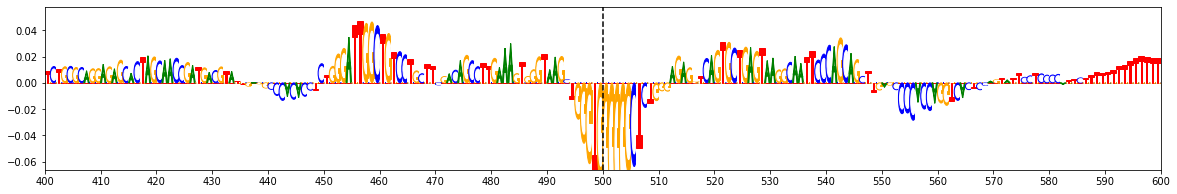

gkmExplain Score: 0.0  ||  ISM Score: 1.0001  ||  deltaSVM Score: 5.7752

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.025079  ||  deltaSVM P-Value: 0.031282

Difference Motif: GGGT(A/G)GGGGG


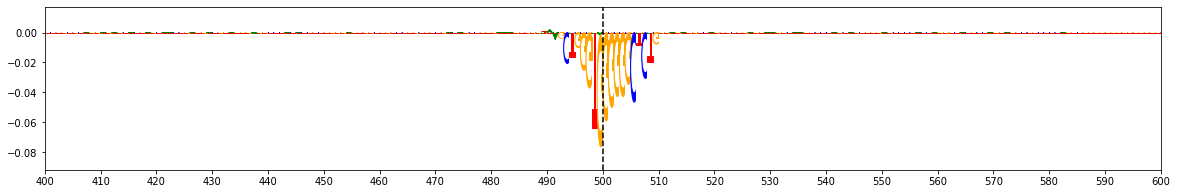



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 62

RSID: rs143560707   ||    chr15 : 64453059 - 64453060   ||    Locus: 43   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 3.0280E-06   ||    Coloc: True   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CACAGCTGTA


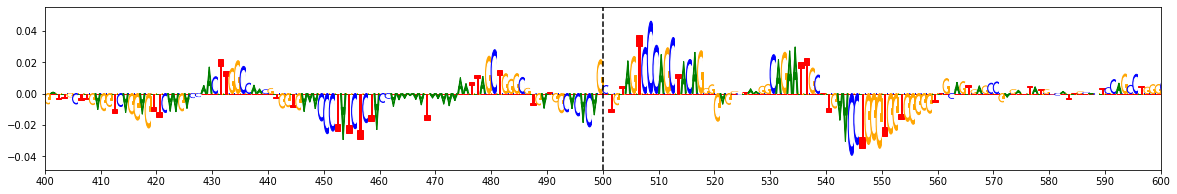

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CACACCTGTA


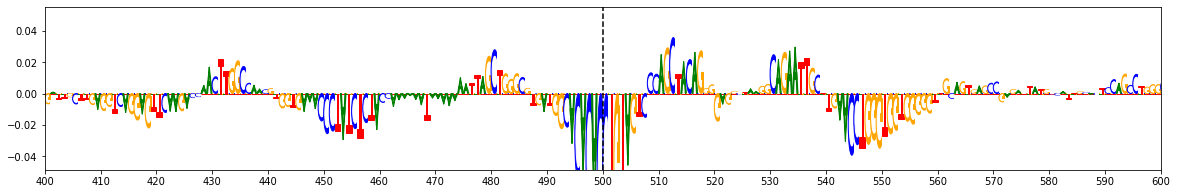

gkmExplain Score: 0.0  ||  ISM Score: 1.5915  ||  deltaSVM Score: 9.1905

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.004662  ||  deltaSVM P-Value: 0.00712

Difference Motif: CACA(G/C)CTGTA


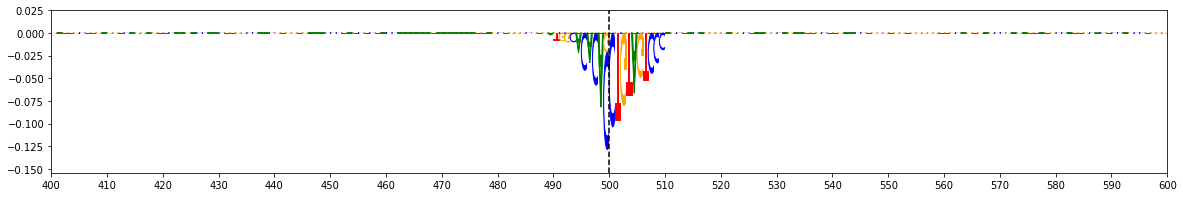



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.29343700408935547
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
I

INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenomet

INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15390324592590332
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pyg

INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09591078758239746
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [sp

INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
I

INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO

INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.06058692932128906
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenom

INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
I

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18683648109436035
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotti

INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
I

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
358,chr3,49007333,49007334,rs6781790,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,True,0.012215,0.016664,0.013196,2,GAGGGCGCTGT,GAGGG(C/T)GCTGT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
235,chr19,18438073,18438074,rs2303696,C,T,+,69,Alzheimers_Kunkle_2019,1.893000e-05,True,True,0.028400,0.037350,0.019764,2,CCCCGCCCC,CCC(C/T)GCCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
94,chr17,4901871,4901872,rs79436576,T,C,+,55,Alzheimers_Lambert_2013,4.789000e-05,True,True,0.016348,0.020051,0.029719,2,GGCCCCGCCCC,GGCC(C/T)CGCCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
151,chr17,45947195,45947196,rs62062785,T,G,-,54,23andme_PD_hg38,3.333700e-22,True,True,0.039209,0.045349,0.033827,2,CCCAGTGGCTGCC,CCCAGTG(G/T)CTGCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
206,chr17,46771150,46771151,rs199523,C,A,-,54,23andme_PD_hg38,9.492900e-14,True,True,0.023943,0.029932,0.048744,2,CGCCACCTAC,(C/A)GCCACCTAC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
262,chr19,44846144,44846145,rs3810143,C,T,+,71,Alzheimers_Jansen_2018,5.975633e-50,True,True,0.018800,0.024062,0.049677,2,ATTCTTTGGCA,ATTCTT(T/C)GGCA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
166,chr17,45955821,45955822,rs112950348,G,A,+,54,23andme_PD_hg38,3.191680e-22,True,True,0.020719,0.026304,0.065121,1,CTCCGCCTCC,CTCC(G/A)CCTCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
152,chr17,45947293,45947294,rs62062786,G,C,+,54,23andme_PD_hg38,4.529580e-22,True,True,0.006017,0.009152,0.065850,1,CAGCTGCCAC,CA(G/C)CTGCCAC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
439,chr8,11845330,11845331,rs1736081,T,G,+,122,Chang_23andMe_Parkinsons,1.114750e-04,False,True,0.022038,0.028084,0.072221,1,CTGTTGGCCC,CTGT(T/G)GGCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
29,chr11,65889092,65889093,rs2231884,T,C,-,13,Alzheimers_Jansen_2018,2.368098e-06,True,True,0.038526,0.046886,0.099567,1,TTCAAAAGC,(T/C)TCAAAAGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
